In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os
import PIL

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

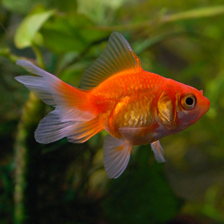

In [4]:
goldfish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
goldfish

In [5]:
goldfish = np.array(goldfish)/255.0
goldfish.shape

(224, 224, 3)

In [6]:
goldfish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [7]:
result = classifier.predict(goldfish[np.newaxis, ...])
result.shape

1/1 [==============================] - 3s 3s/step


(1, 1001)

In [8]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [9]:
with open('ImageNetLabels.txt', 'r') as f:
    labels = f.read().splitlines()

labels[predicted_label_index]

'goldfish'

In [10]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 [==============================] - 11s 0us/step


In [11]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [12]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [13]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/15859434664_67bf3ef29f.jpg'),
 PosixPath('datasets/flower_photos/roses/3103591125_99107c8bbe_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5083072098_81587295d5.jpg'),
 PosixPath('datasets/flower_photos/roses/2408236801_f43c6bcff2.jpg'),
 PosixPath('datasets/flower_photos/roses/14267691818_301aceda07.jpg')]

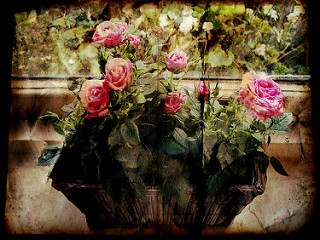

In [14]:
PIL.Image.open(str(roses[1]))

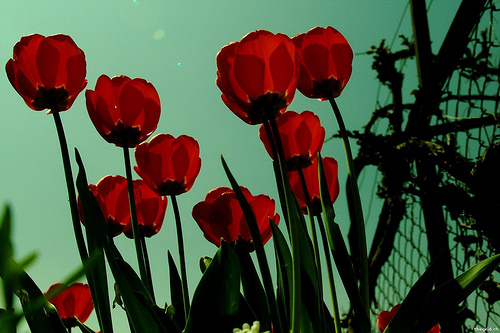

In [15]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [16]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [17]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [18]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(300, 500, 3)

In [19]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [20]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [21]:
X = np.array(X)
y = np.array(y)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [24]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

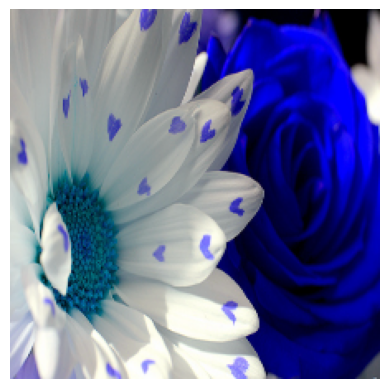

In [25]:
plt.axis('off')
plt.imshow(X[0])

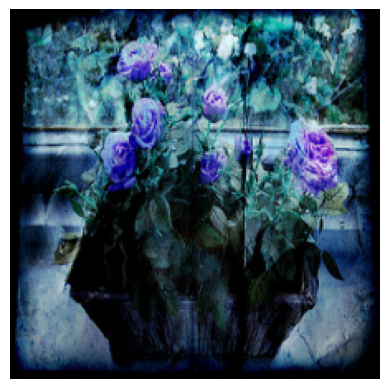

In [26]:
plt.axis('off')
plt.imshow(X[1])

In [27]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 1s/step


array([795, 795, 795])

In [28]:
labels[795]

'shower curtain'

# Now take pre-trained model and retrain it using flowers images

In [29]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [30]:
pretrained_model_without_top_layer  = hub.KerasLayer(
    feature_extractor_model, input_shape=(224,224,3), trainable=False
)

In [31]:
num_of_flowers = 5

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [ ]:
model.fit(X_train_scaled, y_train, epochs=5)

In [ ]:
model.evaluate(X_test_scaled, y_test)